In [24]:
import sys
import numpy as np
import import_ipynb
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve
from pathlib import Path
from IPython.display import SVG, display

# Adicionar o diretório raiz do projeto ao sys.path
project_root = Path().resolve().parent  
sys.path.append(str(project_root))
print("Project root added to sys.path:", project_root)

# Importando notebooks diretamente
try:
    import problem_statement as ps  
    from fem_processing import matrices_assembly, master_domain
    from fem_pos_processing import graph_results
    print("Modules imports were successful!")
except ModuleNotFoundError as en:
    print(f"Modules were not found: {en}")
except ImportError as en:
    print(f"Error in import: {en}")

Project root added to sys.path: C:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF
Modules imports were successful!


# Project 4: Vectorial Poisson Problem at Rectangular Domain $\Omega = [-1,1]^2$

Considere um problema vetorial de _Poisson_ 2D em $\Omega = [-1,1]^2$

$$
\nabla \times \nabla \times \mathbf{u}(\mathbf{x}) + a \mathbf{u}(\mathbf{x}) =
\mathbf{f}(\mathbf{x}) \quad \text{em} \; \Omega = [-1, 1]^2
\tag{1}
$$

$$
\hat{n} \times \mathbf{u} = 0 \quad \text{em} \; \partial \Omega
$$

onde a fonte é dada por,
$$
\mathbf{f}(x,y) = (2\pi^2 + 1)\, 
\begin{pmatrix}
cos(\pi x)  sin(\pi y) \\
-sin(\pi x)  cos(\pi y) \\
\end{pmatrix}
\tag{2}
$$

A solução analítica deste problema é

$$
\mathbf{u}(x,y) = 
\begin{pmatrix}
cos(\pi x)  sin(\pi y) \\
-sin(\pi x)  cos(\pi y) \\
\end{pmatrix}
\tag{3}
$$

Implemente um programa de elementos finitos utilizando elementos de _Nedelec_ do tipo 1, $N_0$, em $R^2$ para resolver o Problema de Valor de Contorno vetorial $(1)$.

# 3-noded Linear Triangular Elements, $P_1$
## Pre-processor module
## Geometry and mesh Domain

In [25]:
FINITE_ELEMENT = ("Triangle", 1)
BOUNDARY = [{'tag': 101, 'type': 'Dirichlet', 'value': 0.0, 'name': 'entire_boundary'}]
MATERIAL = [{'tag': 201, 'name': 'free_space', 'a_constant': 1}]

# Create mesh from file geometry
h = 2
mesh_data = ps.create_meshed_domain(FINITE_ELEMENT, BOUNDARY, MATERIAL, h, view_mesh=False)

Malha salva em pre_processing/mesh/vectorial_poisson_domain_Triangle1.msh
Model vectorial_poisson (2D)
Info     : 9 geometric entities
Info     : 2 Physical Groups
Info     : 5 nodes in total
Info     : 4 2-D elements in total


# Figure 1: Vectorial Shape Functions

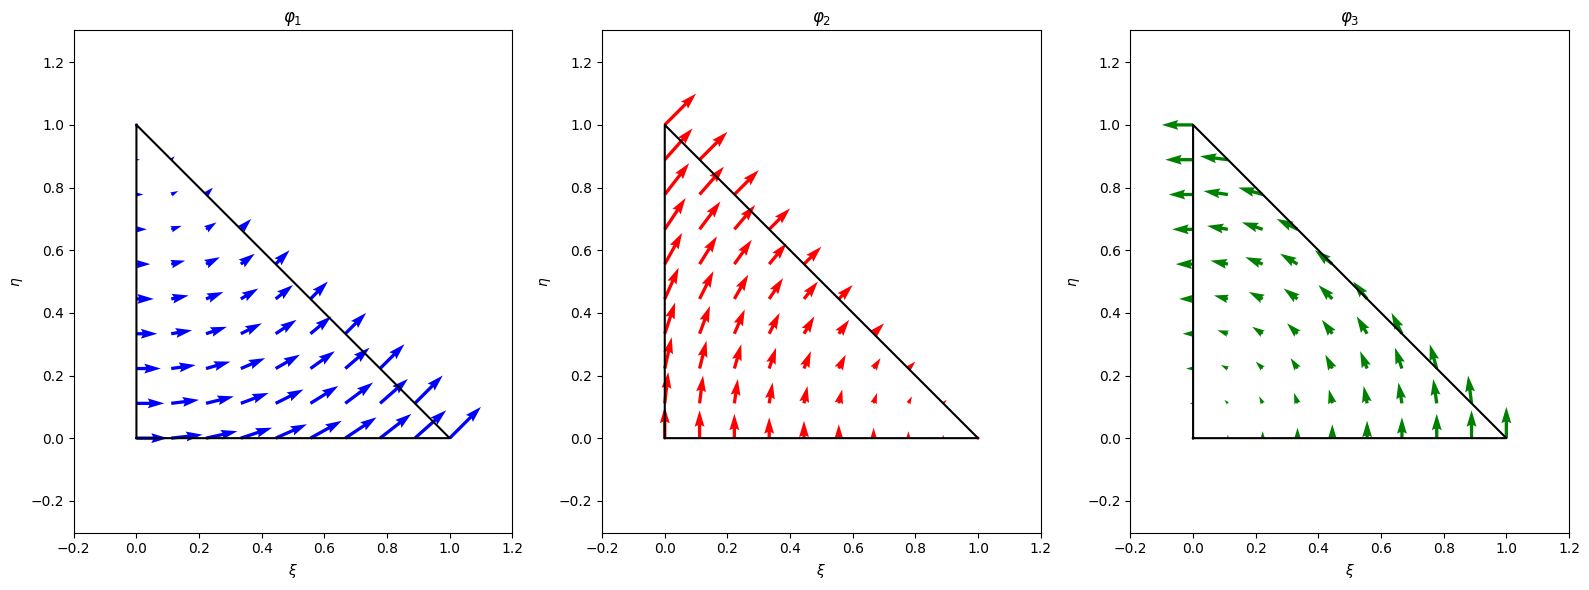

In [26]:
ps.plot_shape_functions_n0()

# Figure 2: Meshed domain

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p41_vectorial_poisson_problem\pre_processing\pictures\meshed_domain_Triangle1_EntireDomain.svg


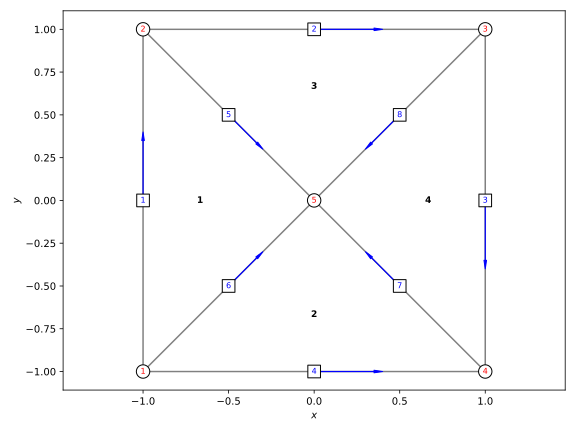

In [27]:
if h == 2:
    graph_results.plot_mesh(FINITE_ELEMENT, mesh_data, numbering=True, show_edges=True)
else:
    graph_results.plot_mesh(FINITE_ELEMENT, mesh_data)
display(SVG(filename="pre_processing/pictures/meshed_domain_Triangle1_EntireDomain.svg"))

In [28]:
# Estruturando os dados da malha
cell_data = mesh_data['cell']
nodes_data = mesh_data['nodes']
edge_data = mesh_data['edges']

ui = {}
for key, edge in edge_data.items():
    # Coordenadas dos nós inicial e final
    xe_0 = nodes_data[edge[0]]['xg'][0]
    ye_0 = nodes_data[edge[0]]['xg'][1]
    xe_1 = nodes_data[edge[1]]['xg'][0]
    ye_1 = nodes_data[edge[1]]['xg'][1]
    
    # Ponto médio da aresta
    xmid, ymid = (xe_0 + xe_1) / 2, (ye_0 + ye_1) / 2
    
    # Vetor tangente à aresta
    tangent_vector = np.array([[xe_1 - xe_0], [ye_1 - ye_0]])

    # Campo vetorial no ponto médio da aresta, u(x_mid, y_mid) 
    u_vector = ps.analytical_function(xmid, ymid)

    # Produto escalar entre o campo vetorial e o vetor tangente
    ## O método .item() extrai o valor escalar de um array de tamanho 1x1
    ui[key] = (u_vector.T @ tangent_vector).item()

In [29]:
## Solution at each element
u_at_cell = {}
for key, cell in cell_data.items():
    xc, yc = cell['centroid']
    phi_hat = master_domain.shape_functions_n0(xc, yc)
    u_at_cell[key] = 0  # Inicializa a solução no elemento como zero
    for i, edge in enumerate(cell['conn_edge']):
        u_at_cell[key] += ui[edge] * phi_hat[i]

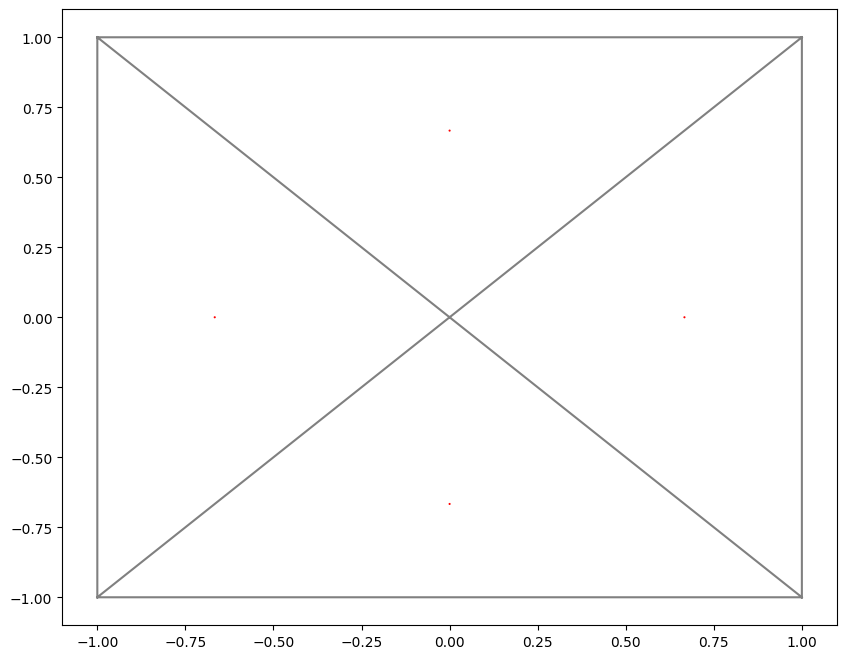

In [30]:
# Extraindo as coordenadas globais dos nós (x, y) e a matriz de conectividade
xg, yg, conn_py = graph_results.structured_data(mesh_data)

# Criando a malha
plt.figure(figsize=(10, 8))
plt.triplot(xg, yg, conn_py, color='gray')

# Adicionando os vetores ao gráfico
for key, cell in cell_data.items():
    if cell['contour']['type'] == 'Dirichlet':
        xc, yc = cell['centroid']
        ux, uy = u_at_cell[key][0], u_at_cell[key][1]
        plt.quiver(xc, yc, ux, uy,
                    angles='xy', scale_units='xy', scale=1, color='r', width=0.003)

# Exibindo o gráfico
plt.show()

In [31]:
{key: cell['conn_sorted'] for key, cell in cell_data.items()}

{1: [1, 2, 5], 2: [1, 4, 5], 3: [2, 3, 5], 4: [3, 4, 5]}

In [32]:
{key: cell['conn_edge'] for key, cell in cell_data.items()}

{1: [1, 6, 5], 2: [4, 6, 7], 3: [2, 5, 8], 4: [3, 8, 7]}

# `plot_analytical_solution()`

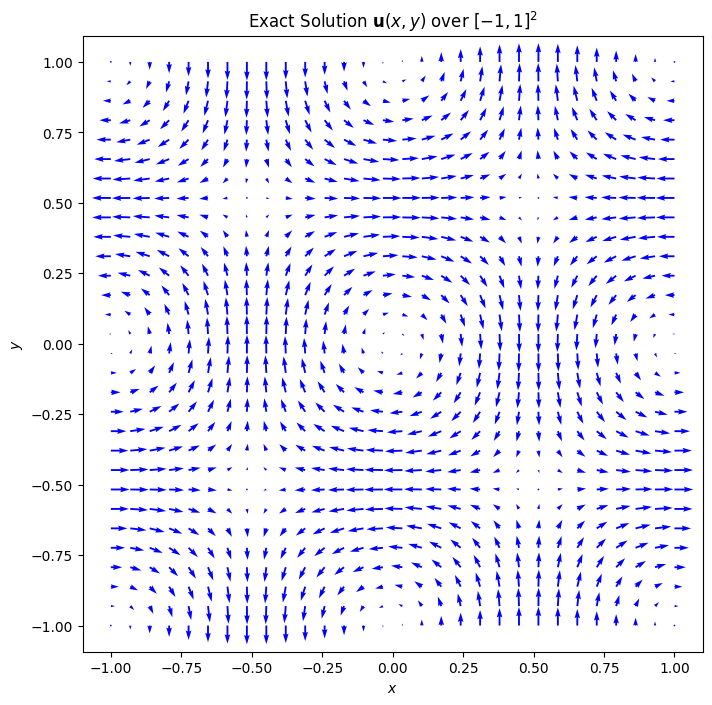

In [33]:
ps.plot_analytical_solution()

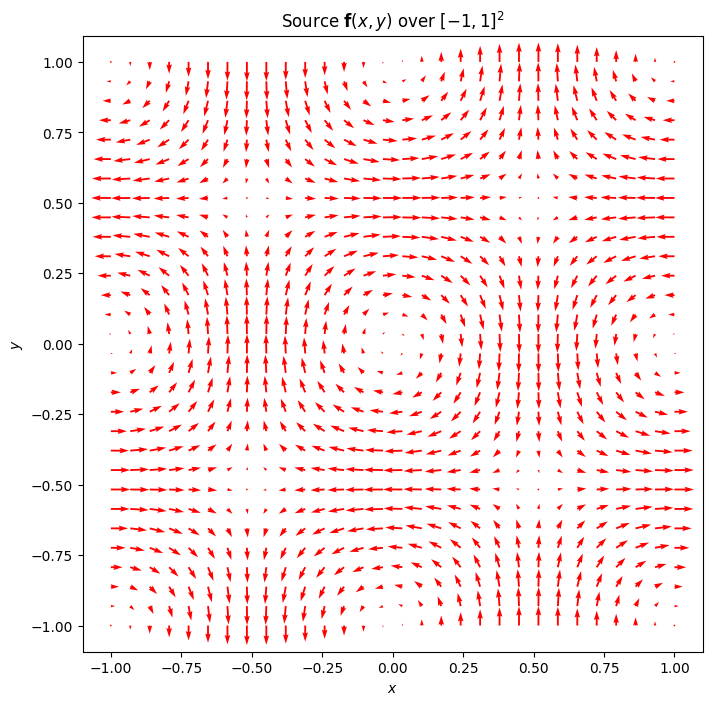

In [34]:
ps.plot_analytical_source()

Conversão do arquivo Jupyter Notebook para um script Python: ``python -m nbconvert --to script name.ipynb``

Belo Horizonte, Brazil. 2025.  
Adilton Junio Ladeira Pereira - adt@ufmg.br  
&copy; All rights reserved.